# LSTM Deep Q Network for different environments 

## 1. Import the libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt #plotting library
from matplotlib import animation #animated visualizations library
from collections import namedtuple, deque 
#nametuple creates tuple subclasses with name fields, access elements by names instead of index
#deque (double-ended queue) for adding and removing elements from both ends
from tqdm import tqdm
#add progress bars to Python code for easy monitoring progress of loops and tasks
# %matplotlib inline 
import gym #environments for agents
from datetime import datetime #manipulating dates and times
import pandas as pd #work with structured data
import torch #Pytorch supports tensor computations and neural networks
import torch.nn as nn #Pytorch supports building neural networks
import torch.nn.functional as F
#common functions in neural network operations 
    # Activation functions (ReLU, sigmoid, tanh)
    # Loss functions (cross_entropy, mse_loss)
    #Utility functions for tensor manipulation (softmax, dropout, batch_norm, etc.)
import torch.optim as optim #optimization algorithms for training neural networks
import random #generate random numbers/selections
from collections import namedtuple, deque 
import itertools 
# provides various functions for creating iterators and combining them for complex interators
# includes cycle, chain, zip, etc.

## 2. LSTM model for approximating Q-values 

In [5]:
hidden_size = 64
num_layers = 3
class QNetwork(nn.Module):
    def __init__(self, state_size, hidden_size, num_layers, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.hidden_dim = hidden_size
        self.layer_dim = num_layers
        
        #LSTM model
        self.lstm = nn.LSTM(input_size=state_size, hidden_size = 64, num_layers = 3, batch_first=True)
        self.fc = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        # Reshape state to have 3 dimensions: batch_size, sequence_length, input_size
        # Assuming state has shape (batch_size, input_size)
        h0 = torch.zeros(self.layer_dim, state.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, state.size(0), self.hidden_dim).requires_grad_()
        # Reshape lstm_out to remove sequence length dimension
        lstm_out, (hn,cn) = self.lstm(state, (h0.detach(), c0.detach()))
        
        lstm_out = self.fc(lstm_out[:, -1, :]) 
        
        return lstm_out

## 3. Implement the replay buffer

In [6]:
device = torch.device("cpu") #Device Initialization

class ReplayBuffer: #Fixed-size buffer to store experience tuples.
    # Initialize a ReplayBuffer object.
    def __init__(self, state_size, action_size, buffer_size, batch_size, priority):
            #state_size(int): dimension of each state
            #action_size (int): dimension of each action 
            #buffer_size (int): max size of buffer 
            #batch_size (int): size of 1 training batch
            #seed (int): random seed
        self.priority = priority        
        #Pointer to keep track of position within the replay buffer where next experiene will be added
        # ptr = 0, new experience added -> increment to ptr = 1
        self. ptr = 0
        #Check if buffer have been filled
        self.n = 0 
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.state_size = state_size
        
        state_size = env.observation_space.shape[0]
        action_size = env.action_space.n

        #create states tensor full of zeros with {buffer_size} rows & {state_size} columns
        #store in device CPU, allocate RAM to it 
        self.states = torch.zeros((1,)+(buffer_size,)+(state_size,)).to(device)
        #Similar to above 
        self.next_states = torch.zeros((1,)+(buffer_size,)+(state_size,)).to(device)
        #Only 1 action taken per experience tuple stored
        # => action size = buffer size rows but 1 column only needed to store
        self.actions = torch.zeros(1, buffer_size, dtype=torch.long).to(device) 
        # Reward same with action
        self.rewards = torch.zeros(1, buffer_size, dtype=torch.float).to(device) 
        
        # Flag to indicate transition/end between an episode ('done' flag)
        # True/False floating values (0.0 False, 1.0 True)
        self.dones = torch.zeros(1, buffer_size, dtype=torch.float).to(device)
        
        # Error in case implement prioritize replay
        self.error = np.zeros((1, buffer_size), dtype=float)
        
        # Priority
        self.priority = priority
    
  # Add new experience to buffer
    def add(self, state, action, reward, next_state, done, state_size):
        
        state_size = env.observation_space.shape[0]

        # Convert state and next_state to appropriate types
        state = torch.tensor(state[0], dtype=torch.float32).reshape(1, 1,state_size)
        state = state.to(device)
            

        next_state = torch.tensor(next_state[0], dtype=torch.float32).reshape(1, 1, state_size)
        next_state = next_state.to(device)
            
        # Convert action, reward, and done flag to tensors
        #action = torch.as_tensor(action, dtype=torch.float32).to(device)
        reward = torch.as_tensor(reward, dtype=torch.float32).to(device)
        done = torch.as_tensor(done, dtype=torch.bool).to(device)
        
        # Store the data in the replay buffer
        self.states[0][self.ptr] = state
        self.next_states[0][self.ptr] = next_state
        self.actions[0][self.ptr] = action
        self.rewards[0][self.ptr] = reward
        self.dones[0][self.ptr] = done
        
        
       
        # Increment the pointer
        self.ptr = (self.ptr + 1) % self.buffer_size

        # Reset pointer and flag when buffer is filled
        if self.ptr == 0:
            self.n = self.buffer_size
        
    #Sample a batch of experience from memory
    def sample(self, get_all=False):
        n = len(self) # Length of the Buffer
        state_size = env.observation_space.shape[0]
        action_size = env.action_space.n
        # Return all experience stored in buffer, no sampling
        if get_all:
            return self.states[:n], self.actions[:n], self.rewards[:n], self.next_states[:n], self.dones[:n]
        
        # else, do sampling: 
        else:
            if self.priority:     
            #enable prioritized experience replay
            #experience are sampled based on priorities probability distribution p = self.error
                idx = np.random.choice(n, self.batch_size, replace=False, p=self.error)
            else: #uniform sampling
                idx = np.random.choice(n, self.batch_size, replace=False)
            #Replace = False to only sample once for each element
            
            states = torch.empty(1, self.batch_size, state_size)
            next_states = torch.empty(1, self.batch_size, state_size)
            actions = torch.empty(1, self.batch_size)
            rewards = torch.empty(1, self.batch_size)
            dones = torch.empty(1, self.batch_size)
            #Retrieve sampled experiences 
            states[0] = self.states[0][idx]
            next_states[0] = self.next_states[0][idx]
            actions[0] = self.actions[0][idx]
            rewards[0] = self.rewards[0][idx]
            dones[0] = self.dones[0][idx]
            
            return (states, actions, rewards, next_states, dones), idx
    
    # Update the error associated with experiences in replay buffer
    def update_error(self, error, idx=None): #specify index number, if not specify, all are updated
        error = torch.abs(error.detach()) #absolute value of errors, detach to prevent gradient computation to be attached to error tensor
        error = error / error.sum() #Normalize, ensure all errors add up to 1
        if idx is not None: #index are specified, then only update specified indices
            self.error[0][idx] = error.cpu().numpy()
        else: # not specify index, all are updated
            self.error[0][:len(self)] = error.cpu().numpy()
    
    # 
    def __len__(self): 
        if self.n == 0:
            return self.ptr
        else:
            return self.n #when buffer is filled self.n stored that size

## 4. Set the parameters

In [7]:
buffer_size = 100000 #Replay buffer size
# batch_size = 3 #Minibatch size
gamma = 0.99 #Discount factor
tau = 1 #Soft update target parameters, tau = 1 = copy completely
alpha = 0.0005 #learning rate
update_every = 4 #How often to update the network

## 5. Agent learning implementation¶

In [8]:
class Agent(): #Learning by interacting with the environment
    def __init__(self, state_size, action_size, hidden_size, num_layers, batch_size, seed, ddqn, priority):
        self.state_size = state_size #Dimension of each state
        self.action_size = action_size #Dimension of action
        self.seed = random.seed(seed) #Choose the random seed
        self.ddqn = ddqn #Store whether agent uses DDQN
        self.priority = priority #Whether uses experience replay
        self.batch_size = batch_size
        #Q-Network
        self.qnetwork_local = QNetwork(state_size, hidden_size, num_layers, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, hidden_size, num_layers, action_size, seed).to(device)
        
        #Initializes optimizer for updating the weights of local Q-Network
        self.optimizer = torch.optim.SGD(self.qnetwork_local.parameters(), lr=alpha)

        # Replay memory
        self.memory = ReplayBuffer(state_size, (action_size,), buffer_size, batch_size, priority)
        # Initialize timestep (to keep track timesteps for updating target)
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done, step_size):
        # Convert states to torch tensors and add batch dimension

        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done, step_size)

        self.t_step += 1  # Increment the timestep counter

        # Update the Q-network after each step in the DQN case
        if not self.ddqn and len(self.memory) > self.batch_size:
            experiences, idx = self.memory.sample()
            error = self.learn(experiences)
            self.memory.update_error(error, idx)

        # In the DDQN case, update the Q-network after a certain number of steps
        if self.ddqn and (self.t_step % update_every) == 0 and len(self.memory) > self.batch_size:
            experiences, idx = self.memory.sample()
            error = self.learn(experiences)
            self.memory.update_error(error, idx)

                
 
    def act(self, state, epsilon):

        state = torch.tensor(state[0], dtype=torch.float32)

        
        self.qnetwork_local.eval()  # Evaluation mode
        with torch.no_grad():  # Disable gradient calculation when choosing action
            state_input = state.view(1,1,-1) #treat this tensor as a single time step of a sequence for a batch size of 1
            action_values = self.qnetwork_local(state_input)  # Pass preprocessed states into local Q-network
        self.qnetwork_local.train()  # Set local Q network back to training mode after inference is complete

        # Epsilon-greedy action selection
        if random.random() > epsilon:
            # Return action with highest Q-value
            action = np.argmax(action_values.cpu().data.numpy())
        else:
            # Select a random action
            action = random.choice(range(self.action_size))
        action = min(max(action, 0), self.action_size - 1) # Ensure action is within valid range
        
        return action   
            
    #Update value parameters using batch of experience tuples
    def learn(self, experiences):
        #experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
        #gamma (float): discount factor
        
        
        states, actions, rewards, next_states, dones = experiences

        ## compute and minimize the loss
        self.optimizer.zero_grad() #Resets all gradients to zero, gradients from previous batches do not accumulate
        if i_episode < 3 or i_episode > 1998:    
            print("Current state: ", state)
            print(" ")
            print("Experiences: ")
            print("States: ", states)
            print("Actions: ", actions)
            print("Rewards: ", rewards)
            print("Next states: ", next_states)
            print(" ")
        #Same as explained above
        if self.ddqn: #DDQN
            old_val = self.qnetwork_local(states).gather(-1, actions)
            if i_episode < 3 or i_episode > 1998:
                print("Q_current: ", old_val)
                print(" ")
            with torch.no_grad():
                if i_episode < 3 or i_episode > 1998:
                    print("All Q values for next_states in order to choose actions, estimate with local network: ")
                    print(self.qnetwork_local(next_states))
                    print(" ")
                next_actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
                if i_episode < 3 or i_episode > 1998:
                    print("Actions, chose with local network = ", next_actions)
                    print(" ")
                    print("All Q values for next_states, estimate with target network: ")
                    print(self.qnetwork_target(next_states))
                    print(" ")
                maxQ = self.qnetwork_target(next_states).gather(-1, next_actions)
                if i_episode < 3 or i_episode > 1998:
                    print("Chosen maximum Q - value from actions gathered above = ", maxQ)
                    print(" ")
                target = rewards+gamma*maxQ*(1-dones)
                if i_episode < 3 or i_episode > 1998:
                    print("Q_target = ", target)
                    print(" ")
        else: # Normal DQN
            old_val = self.qnetwork_local(states)[0][action]
            if i_episode < 3 or i_episode > 1998:
                print("All Q_current: ",self.qnetwork_local(states))
                print(" ")

                print("Q_current: ", old_val)
                print(" ")

            with torch.no_grad():
                if i_episode < 3 or i_episode > 1998:
                    print("All Q values for next_states = ")
                    print(self.qnetwork_target(next_states))
                    print(" ")
                maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
                if i_episode < 3 or i_episode > 1998:
                    print("Chosen maximum Q - value= ", maxQ)
                    print(" ")
                target = reward+gamma*maxQ*(1-done)
                if i_episode < 3 or i_episode > 1998:
                    print("Q_target = ", target)
                    print(" ")
               
        if i_episode < 3 or i_episode > 1998:
            print("Error(Q_target - Q_current): ", target - old_val)
            print(" ")
        
            # mean-squared error for regression
        loss = F.mse_loss(old_val, target) #Calculate loss of current and target Q-values
        loss.backward() #Gradient of loss with respect to Q-network parameters are computed
                        #and used to update the parameters
        self.optimizer.step() #update the neural network
                                #step method applies optimization to update parameters
                                #steps:
                                #1. Optimizer uses computed gradients to update parameters
                                #2. Adam optimizer is applied to each parameter based on the gradients and learning rate
                                #3. Gradients are cleared back to zero as first step for next training iteration

        ##UPDATE THE TARGET NETWORK##
        if not self.ddqn:  # If DQN, update after each episode
            self.soft_update(self.qnetwork_local, self.qnetwork_target, tau) 
        else:  # If DDQN, update after every update_every episodes
            if (self.t_step % update_every) == 0:
                self.soft_update(self.qnetwork_local, self.qnetwork_target, tau)
        
        return old_val - target #temporal difference TD error between old Q and target Q to monitor training progress

    
    def soft_update(self, local_model, target_model, tau):
        #local_model: online model, actively being trained. Weights will be copied from here
        #target_model: use to generate target Q-values during training. Weights will be copied to here
        #tau: interpolation parameters determine rate at which parameters of target models are updated
        #small tau slower update, big tau faster update, less stable
        
        #function iterates over parameters of both target model and local model using zip
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            #for each target param - local param pair, update target param by the formula
            # target_param = tau*local_param + (1-tau)*target_local 
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
    # Function to simulate a model in an environment
    def simulate_model(env_name, model_path):
        # Load the environment
        env = gym.make(env_name)

        # Get environment parameters
        state_size = env.observation_space.shape[0]
        action_size = env.action_space.n

        # Initialize the agent
        agent = Agent(state_size, action_size, seed) 

        # Load the model weights
        agent.qnetwork_local.load_state_dict(torch.load(model_path))
        agent.qnetwork_local.eval()

        # Simulate the model in the environment
        scores = []
        n_episodes = 100  # Number of episodes for simulation
        max_t = 1000  # Maximum number of timesteps per episode

        for i_episode in tqdm(range(1, n_episodes+1)):
            state = env.reset()
            score = 0

            for t in range(max_t):
                action = agent.act(state, epsilon=0.)  # Greedy action selection, no exploration
                state, reward, done, _ = env.step(action)
                score += reward
                if done:
                    break

            scores.append(score)

        # Close the environment
        env.close()

        # Print average score
        print("Average score:", np.mean(scores))

## 6. Training parameters and environments

In [13]:
envs = ['LunarLander-v2'] #list of environments  ,'
#list of implementing algos, each element consists of [DDQN is enabled?, Prioritized experience replay enabled?, type of algo]
algos = [[False, False, 'DQN']] #, [True, False, 'DDQN'], [True, True, 'PriorityDDQN']]
n_episodes = 2000 #number of training episodes
max_t = 1000 #maximum number of timesteps
epsilon_start = 0.99 #starting value of epsilon greedy
epsilon_end = 0.01 #minimum value of epsilon
epsilon_decay = 0.995 #rate at which epsilon decays

## 7. Training implementation

Seed = 1
ENVIRONMENT:----------- LunarLander-v2
Algorithm: DQN


  0%|                                                                                                      | 0/2000 [00:00<?, ?it/s]

Iteration number:  0
Current state:  (array([-0.03171902,  1.3444399 , -0.63850516, -0.644411  ,  0.02830621,
        0.1061321 ,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.0317,  1.3444, -0.6385, -0.6444,  0.0283,  0.1061,  0.0000,
           0.0000],
         [-0.0254,  1.3589, -0.6289, -0.6175,  0.0230,  0.0678,  0.0000,
           0.0000],
         [-0.0128,  1.3861, -0.6482, -0.5639,  0.0147,  0.1453,  0.0000,
           0.0000],
         [-0.0191,  1.3728, -0.6365, -0.5909,  0.0196,  0.0983,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 1., 3., 3.]])
Rewards:  tensor([[-0.9525, -1.7017, -0.1359, -0.2772]])
Next states:  tensor([[[-0.0381,  1.3293, -0.6385, -0.6711,  0.0336,  0.1061,  0.0000,
           0.0000],
         [-0.0317,  1.3444, -0.6385, -0.6444,  0.0283,  0.1061,  0.0000,
           0.0000],
         [-0.0191,  1.3728, -0.6365, -0.5909,  0.0196,  0.0983,  0.0000,
           0.0000],
         [-0.0254,  1.3589, -0.6289, 

C:\Users\phama\AppData\Local\Temp\ipykernel_16512\1174236218.py:138: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(old_val, target) #Calculate loss of current and target Q-values


tensor([[-1.6713]])
 
Error(Q_target - Q_current):  tensor([[-1.6867]], grad_fn=<SubBackward0>)
 
Current state:  (array([-0.06338243,  1.2657909 , -0.6501922 , -0.7156982 ,  0.04939284,
        0.10884927,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.0569,  1.2819, -0.6393, -0.6882,  0.0440,  0.0651,  0.0000,
           0.0000],
         [-0.0128,  1.3861, -0.6482, -0.5639,  0.0147,  0.1453,  0.0000,
           0.0000],
         [-0.0443,  1.3137, -0.6298, -0.6972,  0.0372,  0.0709,  0.0000,
           0.0000],
         [-0.0381,  1.3293, -0.6385, -0.6711,  0.0336,  0.1061,  0.0000,
           0.0000]]])
Actions:  tensor([[1., 3., 0., 3.]])
Rewards:  tensor([[-1.7555, -0.1359, -0.7459, -0.1573]])
Next states:  tensor([[[-0.0634,  1.2658, -0.6502, -0.7157,  0.0494,  0.1088,  0.0000,
           0.0000],
         [-0.0191,  1.3728, -0.6365, -0.5909,  0.0196,  0.0983,  0.0000,
           0.0000],
         [-0.0506,  1.2974, -0.6298, -0.7239,  0.0407

Current state:  (array([-0.1079875 ,  1.1363484 , -0.6278875 , -0.90116096,  0.07414717,
        0.01856121,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.0827,  1.2139, -0.6502, -0.7957,  0.0657,  0.1088,  0.0000,
           0.0000],
         [-0.0891,  1.1954, -0.6394, -0.8219,  0.0690,  0.0652,  0.0000,
           0.0000],
         [-0.0954,  1.1763, -0.6297, -0.8484,  0.0703,  0.0261,  0.0000,
           0.0000],
         [-0.0191,  1.3728, -0.6365, -0.5909,  0.0196,  0.0983,  0.0000,
           0.0000]]])
Actions:  tensor([[3., 3., 1., 3.]])
Rewards:  tensor([[ 0.0685,  0.1767, -1.0820, -0.2772]])
Next states:  tensor([[[-0.0891,  1.1954, -0.6394, -0.8219,  0.0690,  0.0652,  0.0000,
           0.0000],
         [-0.0954,  1.1763, -0.6297, -0.8484,  0.0703,  0.0261,  0.0000,
           0.0000],
         [-0.1017,  1.1566, -0.6378, -0.8755,  0.0732,  0.0589,  0.0000,
           0.0000],
         [-0.0254,  1.3589, -0.6289, -0.6175,  0.0230,  0.

tensor([[-0.1095,  0.0113,  0.1050, -0.0935]])
 
Chosen maximum Q - value=  tensor([[0.1050]])
 
Q_target =  tensor([[0.3707]])
 
Error(Q_target - Q_current):  tensor([[0.4642]], grad_fn=<SubBackward0>)
 
Current state:  (array([-0.15727977,  0.9748568 , -0.6119871 , -0.89957815,  0.0911211 ,
        0.00253141,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.0381,  1.3293, -0.6385, -0.6711,  0.0336,  0.1061,  0.0000,
           0.0000],
         [-0.0827,  1.2139, -0.6502, -0.7957,  0.0657,  0.1088,  0.0000,
           0.0000],
         [-0.0254,  1.3589, -0.6289, -0.6175,  0.0230,  0.0678,  0.0000,
           0.0000],
         [-0.1080,  1.1363, -0.6279, -0.9012,  0.0741,  0.0186,  0.0000,
           0.0000]]])
Actions:  tensor([[3., 3., 1., 2.]])
Rewards:  tensor([[-0.1573,  0.0685, -1.7017,  3.1481]])
Next states:  tensor([[[-0.0443,  1.3137, -0.6298, -0.6972,  0.0372,  0.0709,  0.0000,
           0.0000],
         [-0.0891,  1.1954, -0.6394, -0

Current state:  (array([-0.19371176,  0.84073234, -0.60198605, -1.060136  ,  0.08498938,
       -0.03711165,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.1937,  0.8407, -0.6020, -1.0601,  0.0850, -0.0371,  0.0000,
           0.0000],
         [-0.1573,  0.9749, -0.6120, -0.8996,  0.0911,  0.0025,  0.0000,
           0.0000],
         [-0.0506,  1.2974, -0.6298, -0.7239,  0.0407,  0.0709,  0.0000,
           0.0000],
         [-0.1080,  1.1363, -0.6279, -0.9012,  0.0741,  0.0186,  0.0000,
           0.0000]]])
Actions:  tensor([[2., 1., 2., 2.]])
Rewards:  tensor([[ 3.3563, -1.2708,  2.9091,  3.1481]])
Next states:  tensor([[[-0.1997,  0.8172, -0.6010, -1.0451,  0.0834, -0.0311,  0.0000,
           0.0000],
         [-0.1635,  0.9540, -0.6228, -0.9281,  0.0935,  0.0467,  0.0000,
           0.0000],
         [-0.0569,  1.2819, -0.6393, -0.6882,  0.0440,  0.0651,  0.0000,
           0.0000],
         [-0.1142,  1.1164, -0.6221, -0.8848,  0.0756,  0.

Error(Q_target - Q_current):  tensor([[-0.0941]], grad_fn=<SubBackward0>)
 
Current state:  (array([-0.23504606,  0.6656163 , -0.5790481 , -1.173854  ,  0.0611571 ,
       -0.07483658,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.0317,  1.3444, -0.6385, -0.6444,  0.0283,  0.1061,  0.0000,
           0.0000],
         [-0.1817,  0.8878, -0.6026, -1.0064,  0.0905, -0.0351,  0.0000,
           0.0000],
         [-0.2176,  0.7431, -0.5892, -1.1247,  0.0740, -0.0787,  0.0000,
           0.0000],
         [-0.1757,  0.9105, -0.6026, -0.9797,  0.0922, -0.0351,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 3., 2., 0.]])
Rewards:  tensor([[-9.5248e-01,  6.8657e-01,  2.9584e+00, -1.0662e-03]])
Next states:  tensor([[[-0.0381,  1.3293, -0.6385, -0.6711,  0.0336,  0.1061,  0.0000,
           0.0000],
         [-0.1877,  0.8646, -0.5933, -1.0327,  0.0868, -0.0724,  0.0000,
           0.0000],
         [-0.2235,  0.7178, -0.5808, -1.1214,  0.0706, -0.0

All Q_current:  tensor([[-0.1071,  0.0100,  0.1311, -0.0865]], grad_fn=<AddmmBackward0>)
 
Q_current:  tensor(0.0100, grad_fn=<SelectBackward0>)
 
All Q values for next_states = 
tensor([[-0.1071,  0.0100,  0.1311, -0.0865]])
 
Chosen maximum Q - value=  tensor([[0.1311]])
 
Q_target =  tensor([[-0.8592]])
 
Error(Q_target - Q_current):  tensor([[-0.8692]], grad_fn=<SubBackward0>)
 
Current state:  (array([-0.2760232 ,  0.47670487, -0.5953759 , -1.212509  ,  0.05097526,
        0.02159915,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.1937,  0.8407, -0.6020, -1.0601,  0.0850, -0.0371,  0.0000,
           0.0000],
         [-0.1266,  1.0762, -0.6217, -0.8776,  0.0831,  0.0829,  0.0000,
           0.0000],
         [-0.0954,  1.1763, -0.6297, -0.8484,  0.0703,  0.0261,  0.0000,
           0.0000],
         [-0.2701,  0.5040, -0.5835, -1.1855,  0.0499, -0.0260,  0.0000,
           0.0000]]])
Actions:  tensor([[2., 3., 1., 1.]])
Rewards:  tensor([[ 3.

Current state:  (array([-0.3130253 ,  0.305517  , -0.63515216, -1.2669421 ,  0.07348399,
        0.06568059,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.1388,  1.0349, -0.6107, -0.9303,  0.0869,  0.0382,  0.0000,
           0.0000],
         [-0.2526,  0.5834, -0.5834, -1.2250,  0.0536, -0.0351,  0.0000,
           0.0000],
         [-0.1450,  1.0147, -0.6161, -0.8974,  0.0889,  0.0405,  0.0000,
           0.0000],
         [-0.1205,  1.0959, -0.6314, -0.9116,  0.0789,  0.0665,  0.0000,
           0.0000]]])
Actions:  tensor([[2., 2., 2., 2.]])
Rewards:  tensor([[3.8434, 5.8967, 2.9928, 4.5218]])
Next states:  tensor([[[-0.1450,  1.0147, -0.6161, -0.8974,  0.0889,  0.0405,  0.0000,
           0.0000],
         [-0.2584,  0.5567, -0.5752, -1.1858,  0.0525, -0.0220,  0.0000,
           0.0000],
         [-0.1512,  0.9951, -0.6217, -0.8734,  0.0910,  0.0416,  0.0000,
           0.0000],
         [-0.1266,  1.0762, -0.6217, -0.8776,  0.0831,  0.0829

Current state:  (array([-0.35100308,  0.12802993, -0.66306055, -1.3195344 ,  0.10472268,
        0.13943376,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.3005,  0.3634, -0.6315, -1.2793,  0.0666,  0.1105,  0.0000,
           0.0000],
         [-0.2584,  0.5567, -0.5752, -1.1858,  0.0525, -0.0220,  0.0000,
           0.0000],
         [-0.0317,  1.3444, -0.6385, -0.6444,  0.0283,  0.1061,  0.0000,
           0.0000],
         [-0.2821,  0.4488, -0.6075, -1.2392,  0.0545,  0.0701,  0.0000,
           0.0000]]])
Actions:  tensor([[3., 2., 0., 0.]])
Rewards:  tensor([[-0.5133,  3.9762, -0.9525, -0.7003]])
Next states:  tensor([[[-0.3067,  0.3340, -0.6219, -1.3054,  0.0702,  0.0719,  0.0000,
           0.0000],
         [-0.2642,  0.5307, -0.5835, -1.1589,  0.0512, -0.0260,  0.0000,
           0.0000],
         [-0.0381,  1.3293, -0.6385, -0.6711,  0.0336,  0.1061,  0.0000,
           0.0000],
         [-0.2881,  0.4203, -0.6075, -1.2658,  0.0580,  0.

  0%|                                                                                            | 1/2000 [00:01<1:04:34,  1.94s/it]

Current state:  (array([-0.3982746 , -0.08627418, -0.69478434, -1.2914861 ,  0.1604691 ,
        0.22264414,  1.        ,  1.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.3318,  0.2183, -0.6263, -1.3059,  0.0847,  0.0789,  0.0000,
           0.0000],
         [-0.1817,  0.8878, -0.6026, -1.0064,  0.0905, -0.0351,  0.0000,
           0.0000],
         [-0.3193,  0.2764, -0.6352, -1.2936,  0.0768,  0.0657,  0.0000,
           0.0000],
         [-0.0317,  1.3444, -0.6385, -0.6444,  0.0283,  0.1061,  0.0000,
           0.0000]]])
Actions:  tensor([[1., 3., 2., 0.]])
Rewards:  tensor([[-2.3666,  0.6866,  2.3234, -0.9525]])
Next states:  tensor([[[-0.3381,  0.1883, -0.6348, -1.3326,  0.0903,  0.1132,  0.0000,
           0.0000],
         [-0.1877,  0.8646, -0.5933, -1.0327,  0.0868, -0.0724,  0.0000,
           0.0000],
         [-0.3256,  0.2476, -0.6263, -1.2792,  0.0807,  0.0789,  0.0000,
           0.0000],
         [-0.0381,  1.3293, -0.6385, -0.6711,  0.0336,  0.

Rewards:  tensor([[   0.7606,   -1.1241, -100.0000,    0.6866]])
Next states:  tensor([[[-0.0197,  1.3335, -0.2988, -0.5220,  0.0173,  0.0532,  0.0000,
           0.0000],
         [-0.1205,  1.0959, -0.6314, -0.9116,  0.0789,  0.0665,  0.0000,
           0.0000],
         [-0.4047, -0.0955, -0.5261, -0.0150,  0.0292, -0.3989,  1.0000,
           1.0000],
         [-0.1877,  0.8646, -0.5933, -1.0327,  0.0868, -0.0724,  0.0000,
           0.0000]]])
 
All Q_current:  tensor([[-0.1027, -0.1405,  0.1610, -0.0860]], grad_fn=<AddmmBackward0>)
 
Q_current:  tensor(-0.1405, grad_fn=<SelectBackward0>)
 
All Q values for next_states = 
tensor([[-0.1028, -0.1405,  0.1612, -0.0866]])
 
Chosen maximum Q - value=  tensor([[0.1612]])
 
Q_target =  tensor([[-1.9300]])
 
Error(Q_target - Q_current):  tensor([[-1.7895]], grad_fn=<SubBackward0>)
 
Current state:  (array([-0.022717  ,  1.3211827 , -0.30871946, -0.5488111 ,  0.02198387,
        0.09299751,  0.        ,  0.        ], dtype=float32), {})
 


Current state:  (array([-0.04043512,  1.2344921 , -0.29872304, -0.7090093 ,  0.03667299,
        0.0527365 ,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.3709,  0.0368, -0.6856, -1.3392,  0.1251,  0.1281,  0.0000,
           0.0000],
         [-0.3576,  0.0978, -0.6631, -1.3462,  0.1117,  0.1394,  0.0000,
           0.0000],
         [-0.0197,  1.3335, -0.2988, -0.5220,  0.0173,  0.0532,  0.0000,
           0.0000],
         [-0.0763,  1.2318, -0.6502, -0.7690,  0.0603,  0.1088,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 0., 1., 0.]])
Rewards:  tensor([[-3.5214, -3.0472, -2.0896, -0.8517]])
Next states:  tensor([[[-0.3777,  0.0060, -0.6856, -1.3658,  0.1315,  0.1281,  0.0000,
           0.0000],
         [-0.3641,  0.0669, -0.6631, -1.3729,  0.1187,  0.1394,  0.0000,
           0.0000],
         [-0.0227,  1.3212, -0.3087, -0.5488,  0.0220,  0.0930,  0.0000,
           0.0000],
         [-0.0827,  1.2139, -0.6502, -0.7957,  0.0657,  0.

Q_target =  tensor([[1.7096]])
 
Error(Q_target - Q_current):  tensor([[1.5370]], grad_fn=<SubBackward0>)
 
Current state:  (array([-0.06185341,  1.1187223 , -0.32989964, -0.73003983,  0.03307622,
       -0.00891577,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.0139,  1.3572, -0.2773, -0.5022,  0.0116,  0.0151,  0.0000,
           0.0000],
         [-0.3256,  0.2476, -0.6263, -1.2792,  0.0807,  0.0789,  0.0000,
           0.0000],
         [-0.3641,  0.0669, -0.6631, -1.3729,  0.1187,  0.1394,  0.0000,
           0.0000],
         [-0.2176,  0.7431, -0.5892, -1.1247,  0.0740, -0.0787,  0.0000,
           0.0000]]])
Actions:  tensor([[1., 0., 2., 2.]])
Rewards:  tensor([[-2.0843, -1.6039,  0.8219,  2.9584]])
Next states:  tensor([[[-0.0167,  1.3453, -0.2891, -0.5292,  0.0147,  0.0623,  0.0000,
           0.0000],
         [-0.3318,  0.2183, -0.6263, -1.3059,  0.0847,  0.0789,  0.0000,
           0.0000],
         [-0.3709,  0.0368, -0.6856, -1.339

Actions:  tensor([[3., 0., 1., 1.]])
Rewards:  tensor([[-0.2772, -0.7003, -1.2708, -1.0820]])
Next states:  tensor([[[-0.0254,  1.3589, -0.6289, -0.6175,  0.0230,  0.0678,  0.0000,
           0.0000],
         [-0.2881,  0.4203, -0.6075, -1.2658,  0.0580,  0.0701,  0.0000,
           0.0000],
         [-0.1635,  0.9540, -0.6228, -0.9281,  0.0935,  0.0467,  0.0000,
           0.0000],
         [-0.1017,  1.1566, -0.6378, -0.8755,  0.0732,  0.0589,  0.0000,
           0.0000]]])
 
All Q_current:  tensor([[-0.1060, -0.1502,  0.1868, -0.0862]], grad_fn=<AddmmBackward0>)
 
Q_current:  tensor(-0.0862, grad_fn=<SelectBackward0>)
 
All Q values for next_states = 
tensor([[-0.1059, -0.1502,  0.1868, -0.0862]])
 
Chosen maximum Q - value=  tensor([[0.1868]])
 
Q_target =  tensor([[0.7156]])
 
Error(Q_target - Q_current):  tensor([[0.8019]], grad_fn=<SubBackward0>)
 
Current state:  (array([-0.10151301,  0.89353293, -0.29963833, -0.93158734,  0.00230839,
       -0.16025622,  0.        ,  0.      

States:  tensor([[[-0.0197,  1.3335, -0.2988, -0.5220,  0.0173,  0.0532,  0.0000,
           0.0000],
         [-0.2176,  0.7431, -0.5892, -1.1247,  0.0740, -0.0787,  0.0000,
           0.0000],
         [-0.2350,  0.6656, -0.5790, -1.1739,  0.0612, -0.0748,  0.0000,
           0.0000],
         [-0.0854,  0.9938, -0.3328, -0.8656,  0.0240, -0.0391,  0.0000,
           0.0000]]])
Actions:  tensor([[1., 2., 0., 0.]])
Rewards:  tensor([[-2.0896,  2.9584,  0.3152, -0.3281]])
Next states:  tensor([[[-0.0227,  1.3212, -0.3087, -0.5488,  0.0220,  0.0930,  0.0000,
           0.0000],
         [-0.2235,  0.7178, -0.5808, -1.1214,  0.0706, -0.0673,  0.0000,
           0.0000],
         [-0.2409,  0.6386, -0.5790, -1.2005,  0.0574, -0.0748,  0.0000,
           0.0000],
         [-0.0887,  0.9738, -0.3328, -0.8923,  0.0221, -0.0391,  0.0000,
           0.0000]]])
 
All Q_current:  tensor([[-0.1091, -0.1540,  0.1918, -0.0883]], grad_fn=<AddmmBackward0>)
 
Q_current:  tensor(-0.1540, grad_fn=<Selec

All Q_current:  tensor([[-0.1089, -0.1546,  0.2056, -0.0884]], grad_fn=<AddmmBackward0>)
 
Q_current:  tensor(-0.0884, grad_fn=<SelectBackward0>)
 
All Q values for next_states = 
tensor([[-0.1088, -0.1546,  0.2056, -0.0884]])
 
Chosen maximum Q - value=  tensor([[0.2056]])
 
Q_target =  tensor([[-0.0932]])
 
Error(Q_target - Q_current):  tensor([[-0.0048]], grad_fn=<SubBackward0>)
 
Current state:  (array([-0.15553045,  0.44529262, -0.28824306, -1.2176836 , -0.13028805,
       -0.07771836,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.1997,  0.8172, -0.6010, -1.0451,  0.0834, -0.0311,  0.0000,
           0.0000],
         [-0.0698,  1.2491, -0.6502, -0.7424,  0.0548,  0.1088,  0.0000,
           0.0000],
         [-0.0443,  1.3137, -0.6298, -0.6972,  0.0372,  0.0709,  0.0000,
           0.0000],
         [-0.3444,  0.1577, -0.6437, -1.3594,  0.0978,  0.1487,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 0., 0., 2.]])
Rewards:  tensor([[ 0

Current state:  (array([-0.17306098,  0.27060565, -0.29302838, -1.3435346 , -0.16356547,
       -0.11103139,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.3444,  0.1577, -0.6437, -1.3594,  0.0978,  0.1487,  0.0000,
           0.0000],
         [-0.0752,  1.0505, -0.3345, -0.7854,  0.0271, -0.0322,  0.0000,
           0.0000],
         [-0.1405,  0.5793, -0.3051, -1.2083, -0.1120, -0.0772,  0.0000,
           0.0000],
         [-0.2701,  0.5040, -0.5835, -1.1855,  0.0499, -0.0260,  0.0000,
           0.0000]]])
Actions:  tensor([[2., 0., 2., 1.]])
Rewards:  tensor([[ 2.2553, -0.5857,  2.4428, -0.9890]])
Next states:  tensor([[[-0.3510,  0.1280, -0.6631, -1.3195,  0.1047,  0.1394,  0.0000,
           0.0000],
         [-0.0786,  1.0322, -0.3345, -0.8130,  0.0255, -0.0322,  0.0000,
           0.0000],
         [-0.1435,  0.5523, -0.3022, -1.2029, -0.1160, -0.0796,  0.0000,
           0.0000],
         [-0.2760,  0.4767, -0.5954, -1.2125,  0.0510,  0.

  0%|                                                                                            | 2/2000 [00:04<1:09:25,  2.08s/it]

All Q_current:  tensor([[-0.1163, -0.1552,  0.2247, -0.0891]], grad_fn=<AddmmBackward0>)
 
Q_current:  tensor(-0.1163, grad_fn=<SelectBackward0>)
 
All Q values for next_states = 
tensor([[-0.1163, -0.1551,  0.2247, -0.0891]])
 
Chosen maximum Q - value=  tensor([[0.2247]])
 
Q_target =  tensor([[-2.3932]])
 
Error(Q_target - Q_current):  tensor([[-2.2769]], grad_fn=<SubBackward0>)
 
Current state:  (array([-0.1935503 ,  0.03121878, -0.24277572, -1.407003  , -0.20481645,
       -0.09958205,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.0375,  1.2504, -0.2903, -0.6825,  0.0340,  0.0191,  0.0000,
           0.0000],
         [-0.1467,  0.5257, -0.3089, -1.1827, -0.1207, -0.0940,  0.0000,
           0.0000],
         [-0.1512,  0.9951, -0.6217, -0.8734,  0.0910,  0.0416,  0.0000,
           0.0000],
         [-0.1080,  1.1363, -0.6279, -0.9012,  0.0741,  0.0186,  0.0000,
           0.0000]]])
Actions:  tensor([[1., 2., 3., 2.]])
Rewards:  tensor([[-1

100%|██████████████████████████████████████████████████████████████████████████████████████████▉| 1998/2000 [40:07<00:02,  1.09s/it]

Iteration number:  1998
Current state:  (array([ 0.00543795,  1.4153314 ,  0.55079067,  0.19604398, -0.00629445,
       -0.12476232,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[ 0.1005,  0.3791,  0.1551, -1.5532, -0.0965,  0.0029,  0.0000,
           0.0000],
         [-0.0394,  1.3983, -0.4981, -0.1634,  0.0447,  0.1115,  0.0000,
           0.0000],
         [ 0.1134,  1.2110,  0.7650, -0.7795, -0.1286, -0.1710,  0.0000,
           0.0000],
         [ 0.0266,  1.0771,  0.1418, -1.0209, -0.0302, -0.0317,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 0., 0., 0.]])
Rewards:  tensor([[ 0.7416, -1.0381, -1.0459, -0.4481]])
Next states:  tensor([[[ 0.1020,  0.3435,  0.1551, -1.5799, -0.0963,  0.0029,  0.0000,
           0.0000],
         [-0.0443,  1.3940, -0.4981, -0.1901,  0.0503,  0.1115,  0.0000,
           0.0000],
         [ 0.1210,  1.1928,  0.7650, -0.8062, -0.1371, -0.1710,  0.0000,
           0.0000],
         [ 0.0280,  1.0535,  0.141

tensor([[-82.1871, -99.2152, -92.7665, -96.8783]])
 
Chosen maximum Q - value=  tensor([[-82.1871]])
 
Q_target =  tensor([[-81.9784]])
 
Error(Q_target - Q_current):  tensor([[0.2089]], grad_fn=<SubBackward0>)
 
Current state:  (array([ 0.04894857,  1.429219  ,  0.5501737 , -0.01632362, -0.05556963,
       -0.12312537,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.0399,  1.3104, -0.5047, -0.6516,  0.0453,  0.1130,  0.0000,
           0.0000],
         [-0.1204,  1.1806, -0.2647, -0.8231,  0.1361,  0.0591,  0.0000,
           0.0000],
         [-0.1641,  0.7870, -0.3951, -1.2077,  0.1855,  0.0882,  0.0000,
           0.0000],
         [-0.0722,  1.4428, -0.4388, -0.0975,  0.0798,  0.0876,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 0., 3., 0.]])
Rewards:  tensor([[-1.1814, -0.9636,  0.2375, -0.8360]])
Next states:  tensor([[[-0.0449,  1.2952, -0.5047, -0.6783,  0.0510,  0.1130,  0.0000,
           0.0000],
         [-0.1230,  1.1615, -0.

Current state:  (array([ 0.09247275,  1.4047363 ,  0.5503137 , -0.2296998 , -0.10478067,
       -0.12297218,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.0198,  1.4336, -0.4997,  0.2125,  0.0225,  0.1119,  0.0000,
           0.0000],
         [ 0.0535,  1.2741,  0.4162, -0.6279, -0.0606, -0.0931,  0.0000,
           0.0000],
         [ 0.1282,  0.9358,  0.4051, -1.0741, -0.1450, -0.0904,  0.0000,
           0.0000],
         [-0.0240,  1.5039, -0.1515,  0.0584,  0.0272,  0.0339,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 0., 0., 0.]])
Rewards:  tensor([[ 3.1336e-04, -1.2501e+00, -5.5547e-01,  5.1468e-01]])
Next states:  tensor([[[-0.0247,  1.4378, -0.4997,  0.1859,  0.0281,  0.1119,  0.0000,
           0.0000],
         [ 0.0576,  1.2594,  0.4162, -0.6546, -0.0653, -0.0931,  0.0000,
           0.0000],
         [ 0.1322,  0.9111,  0.4051, -1.1008, -0.1495, -0.0904,  0.0000,
           0.0000],
         [-0.0255,  1.5047, -0.1515,  0.03

Current state:  (array([ 0.13601093,  1.3418813 ,  0.55044705, -0.44308472, -0.15393162,
       -0.12282388,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.1242,  0.0463, -0.6107, -1.6689,  2.4228,  0.0480,  0.0000,
           0.0000],
         [ 0.2143,  1.4136,  0.7742, -0.3574, -0.2429, -0.1728,  0.0000,
           0.0000],
         [ 0.4034, -0.0850, -0.5417, -0.7560, -0.1974,  3.1888,  1.0000,
           1.0000],
         [-0.2452,  1.2594, -0.6357, -0.6806,  0.2776,  0.1419,  0.0000,
           0.0000]]])
Actions:  tensor([[3., 0., 0., 0.]])
Rewards:  tensor([[-100.0000,   -1.2819, -100.0000,   -1.2401]])
Next states:  tensor([[[-0.1305,  0.0173, -0.5798, -0.0271,  2.4430,  1.7449,  0.0000,
           0.0000],
         [ 0.2220,  1.4050,  0.7742, -0.3840, -0.2515, -0.1728,  0.0000,
           0.0000],
         [ 0.3995, -0.1008, -0.6225, -0.5964, -0.0369,  3.6836,  1.0000,
           1.0000],
         [-0.2514,  1.2436, -0.6357, -0.7073,  0.2

Next states:  tensor([[[-0.1751,  0.1300, -0.3279, -1.7616,  0.1979,  0.0732,  0.0000,
           0.0000],
         [-0.2836,  1.3095, -0.7967, -0.5936,  0.3211,  0.1778,  0.0000,
           0.0000],
         [-0.0969,  1.1258, -0.5892, -0.9416,  0.1200,  0.1524,  0.0000,
           0.0000],
         [-0.1341,  1.0914, -0.6167, -0.9260,  0.1518,  0.1377,  0.0000,
           0.0000]]])
 
All Q_current:  tensor([[-82.6761, -99.2274, -92.7771, -96.8900]], grad_fn=<AddmmBackward0>)
 
Q_current:  tensor(-82.6761, grad_fn=<SelectBackward0>)
 
All Q values for next_states = 
tensor([[-82.6758, -99.2270, -92.7767, -96.8896]])
 
Chosen maximum Q - value=  tensor([[-82.6758]])
 
Q_target =  tensor([[-83.0836]])
 
Error(Q_target - Q_current):  tensor([[-0.4076]], grad_fn=<SubBackward0>)
 
Current state:  (array([ 0.18497686,  1.225126  ,  0.55023885, -0.6840579 , -0.20959345,
       -0.12279731,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[ 0.1411,  0.8133,  0

Q_current:  tensor(-82.8114, grad_fn=<SelectBackward0>)
 
All Q values for next_states = 
tensor([[-82.8116, -99.2196, -92.7700, -96.8824]])
 
Chosen maximum Q - value=  tensor([[-82.8116]])
 
Q_target =  tensor([[-83.0284]])
 
Error(Q_target - Q_current):  tensor([[-0.2170]], grad_fn=<SubBackward0>)
 
Current state:  (array([ 0.22306947,  1.1007347 ,  0.55023146, -0.870746  , -0.25257203,
       -0.12279488,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[ 0.1376,  0.3504,  0.2898, -1.6093, -0.1555, -0.0647,  0.0000,
           0.0000],
         [-0.1074,  1.3103, -0.3504, -0.5452,  0.1215,  0.0782,  0.0000,
           0.0000],
         [-0.3514,  0.5469, -0.5642, -1.4181,  0.4200,  0.1373,  0.0000,
           0.0000],
         [ 0.4412,  0.6324,  0.7112, -1.3617, -0.5013, -0.1600,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 0., 0., 0.]])
Rewards:  tensor([[ 0.3344, -1.3973, -0.7774, -1.0518]])
Next states:  tensor([[[ 0.1404,  0.3136,  0.28

Current state:  (array([ 0.2611662 ,  0.9469671 ,  0.5502226 , -1.057434  , -0.2955498 ,
       -0.12279274,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.2337,  0.9952, -0.7162, -0.9296,  0.2628,  0.1521,  0.0000,
           0.0000],
         [ 0.1365,  1.5046,  0.6575, -0.0689, -0.1546, -0.1468,  0.0000,
           0.0000],
         [ 0.1613,  0.9071,  0.4478, -1.0890, -0.1445, -0.0625,  0.0000,
           0.0000],
         [-0.1332,  0.5326, -0.3368, -1.4967,  0.1506,  0.0752,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 0., 0., 0.]])
Rewards:  tensor([[-0.9615, -0.9146, -0.3944,  0.2518]])
Next states:  tensor([[[-0.2408,  0.9737, -0.7162, -0.9563,  0.2704,  0.1521,  0.0000,
           0.0000],
         [ 0.1430,  1.5024,  0.6576, -0.0956, -0.1619, -0.1468,  0.0000,
           0.0000],
         [ 0.1658,  0.8820,  0.4478, -1.1157, -0.1477, -0.0625,  0.0000,
           0.0000],
         [-0.1365,  0.4984, -0.3368, -1.5233,  0.1544,  0.

Current state:  (array([ 0.29926777,  0.7638229 ,  0.5502125 , -1.2441217 , -0.33852684,
       -0.12279063,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[ 0.1350,  0.6415,  0.3296, -1.3619, -0.2183, -0.1155,  0.0000,
           0.0000],
         [-0.6166,  0.1928, -0.7193, -1.7634,  0.6522,  0.1293,  0.0000,
           0.0000],
         [-0.0250,  1.3931, -0.0880,  0.2033,  0.0809,  0.0829,  0.0000,
           0.0000],
         [-0.4674,  0.6490, -0.6847, -1.3993,  0.5282,  0.1528,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 0., 2., 0.]])
Rewards:  tensor([[-0.1894, -2.7278, -3.7187, -0.9991]])
Next states:  tensor([[[ 0.1383,  0.6103,  0.3296, -1.3886, -0.2241, -0.1155,  0.0000,
           0.0000],
         [-0.6237,  0.1526, -0.7193, -1.7900,  0.6587,  0.1293,  0.0000,
           0.0000],
         [-0.0257,  1.3984, -0.0779,  0.2328,  0.0858,  0.0993,  0.0000,
           0.0000],
         [-0.4742,  0.6170, -0.6847, -1.4259,  0.5358,  0.

All Q_current:  tensor([[-82.7115, -99.2237, -92.7738, -96.8865]], grad_fn=<AddmmBackward0>)
 
Q_current:  tensor(-82.7115, grad_fn=<SelectBackward0>)
 
All Q values for next_states = 
tensor([[-82.7114, -99.2235, -92.7736, -96.8863]])
 
Chosen maximum Q - value=  tensor([[-82.7114]])
 
Q_target =  tensor([[-82.5184]])
 
Error(Q_target - Q_current):  tensor([[0.1931]], grad_fn=<SubBackward0>)
 
Current state:  (array([ 0.34281912,  0.51854366,  0.55019915, -1.4574784 , -0.3876425 ,
       -0.12278803,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.0832,  0.9379, -0.2003, -1.0479,  0.0941,  0.0447,  0.0000,
           0.0000],
         [ 0.3607, -0.0846,  0.0382, -0.3704, -2.7328, -0.9553,  1.0000,
           0.0000],
         [-0.0447,  1.2882, -0.3254, -0.4386,  0.7832,  0.3929,  0.0000,
           0.0000],
         [ 0.0175,  1.3985,  0.3534, -0.1638, -0.0199, -0.0792,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 0., 0., 0.]])
Rewards:  

100%|██████████████████████████████████████████████████████████████████████████████████████████▉| 1999/2000 [40:09<00:01,  1.39s/it]

Current state:  (array([ 0.3809331 ,  0.27244872,  0.55018616, -1.6441653 , -0.43061787,
       -0.12278581,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[ 0.2873,  0.6088,  0.7646, -1.4331, -0.3252, -0.1706,  0.0000,
           0.0000],
         [ 0.0672,  1.4946,  0.6801,  0.2516, -0.0763, -0.1522,  0.0000,
           0.0000],
         [-0.3445,  0.2568, -0.5903, -1.6441,  0.3892,  0.1318,  0.0000,
           0.0000],
         [ 0.6033, -0.1256,  0.6008, -1.6690, -0.5534, -0.1118,  1.0000,
           0.0000]]])
Actions:  tensor([[0., 0., 0., 0.]])
Rewards:  tensor([[  -0.6010,   -0.4191,   -1.5315, -100.0000]])
Next states:  tensor([[[ 0.2949,  0.5760,  0.7646, -1.4598, -0.3338, -0.1706,  0.0000,
           0.0000],
         [ 0.0740,  1.4996,  0.6801,  0.2249, -0.0839, -0.1521,  0.0000,
           0.0000],
         [-0.3503,  0.2193, -0.5903, -1.6707,  0.3958,  0.1318,  0.0000,
           0.0000],
         [ 0.6086, -0.1329,  0.3358, -0.2730, -0.3

Iteration number:  1999
Current state:  (array([ 0.00471973,  1.4090972 ,  0.47803965, -0.08103362, -0.00546217,
       -0.10828307,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[ 0.0127,  1.2205,  0.0990, -0.8109, -0.0144, -0.0221,  0.0000,
           0.0000],
         [ 0.3870, -0.0295,  0.7383, -1.9030, -0.4376, -0.1648,  1.0000,
           0.0000],
         [-0.1878,  0.6164, -0.4999, -1.4236,  0.2124,  0.1116,  0.0000,
           0.0000],
         [-0.4754,  0.7720, -0.4993, -1.0118,  0.1614, -0.6188,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 0., 0., 3.]])
Rewards:  tensor([[  -0.8753, -100.0000,   -0.1175,    3.2166]])
Next states:  tensor([[[ 0.0137,  1.2017,  0.0990, -0.8375, -0.0155, -0.0221,  0.0000,
           0.0000],
         [ 0.3964, -0.0601,  0.7824, -0.9875, -0.2429,  6.1424,  1.0000,
           0.0000],
         [-0.1928,  0.5838, -0.4999, -1.4503,  0.2180,  0.1116,  0.0000,
           0.0000],
         [-0.4807,  0.7486

Actions:  tensor([[0., 0., 0., 0.]])
Rewards:  tensor([[-1.7311, -1.2783, -0.2550,  0.0337]])
Next states:  tensor([[[ 0.0031,  1.4010,  0.1560, -0.2335, -0.0035, -0.0350,  0.0000,
           0.0000],
         [-0.1512,  1.2856, -0.6373, -0.5393,  0.1711,  0.1422,  0.0000,
           0.0000],
         [ 0.1815,  0.6876,  0.4589, -1.3247, -0.2052, -0.1024,  0.0000,
           0.0000],
         [ 0.2212,  0.3840,  0.4362, -1.5622, -0.1457, -0.0553,  0.0000,
           0.0000]]])
 
All Q_current:  tensor([[-83.6676, -99.2334, -92.7818, -96.8955]], grad_fn=<AddmmBackward0>)
 
Q_current:  tensor(-83.6676, grad_fn=<SelectBackward0>)
 
All Q values for next_states = 
tensor([[-83.6676, -99.2334, -92.7819, -96.8956]])
 
Chosen maximum Q - value=  tensor([[-83.6676]])
 
Q_target =  tensor([[-84.0699]])
 
Error(Q_target - Q_current):  tensor([[-0.4023]], grad_fn=<SubBackward0>)
 
Current state:  (array([ 0.04248333,  1.3731059 ,  0.47750473, -0.2933953 , -0.04822901,
       -0.10686308,  0.     

Error(Q_target - Q_current):  tensor([[-0.5084]], grad_fn=<SubBackward0>)
 
Current state:  (array([ 0.07553577,  1.3101315 ,  0.47761163, -0.48009297, -0.08560447,
       -0.10674751,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.1964,  1.2302, -0.6849, -0.6518,  0.2226,  0.1529,  0.0000,
           0.0000],
         [-0.0335,  0.0091, -0.0462, -1.8085, -0.0102, -0.0048,  0.0000,
           0.0000],
         [-0.0872,  0.9059, -0.2738, -1.0987,  0.1407,  0.1165,  0.0000,
           0.0000],
         [-0.0312,  1.4585, -0.6308,  0.3694,  0.0355,  0.1413,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 0., 0., 0.]])
Rewards:  tensor([[-1.2274, 16.1020, -0.6802, -0.1830]])
Next states:  tensor([[[-0.2032,  1.2149, -0.6849, -0.6785,  0.2302,  0.1529,  0.0000,
           0.0000],
         [-0.0340, -0.0322, -0.0462, -1.8352, -0.0105, -0.0048,  1.0000,
           1.0000],
         [-0.0899,  0.8806, -0.2738, -1.1254,  0.1465,  0.1165,  0.0000,
  

tensor([[-84.1007, -99.2389, -92.7864, -96.9008]])
 
Chosen maximum Q - value=  tensor([[-84.1007]])
 
Q_target =  tensor([[-84.4665]])
 
Error(Q_target - Q_current):  tensor([[-0.3657]], grad_fn=<SubBackward0>)
 
Current state:  (array([ 0.11332102,  1.2021798 ,  0.47772902, -0.69346845, -0.12827067,
       -0.10661912,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.1780,  0.8444, -0.4091, -1.1465,  0.2012,  0.0913,  0.0000,
           0.0000],
         [ 0.4231,  0.6169,  0.6013, -1.4159, -0.4412, -0.1106,  0.0000,
           0.0000],
         [ 0.2154,  0.0038,  0.3571, -1.8260, -0.2434, -0.0797,  1.0000,
           0.0000],
         [-0.0229,  1.3599, -0.3309, -0.4040,  0.0260,  0.0741,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 0., 0., 0.]])
Rewards:  tensor([[  -0.4788,   -0.7118, -100.0000,   -1.4978]])
Next states:  tensor([[[-0.1820,  0.8180, -0.4091, -1.1731,  0.2058,  0.0913,  0.0000,
           0.0000],
         [ 0.4290,  0.

Current state:  (array([ 0.14637843,  1.0761116 ,  0.47756177, -0.88110363, -0.1655771 ,
       -0.10658865,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.3226,  0.7102, -0.4869, -1.3459,  0.3644,  0.1087,  0.0000,
           0.0000],
         [ 0.1212,  0.2030,  0.2451, -1.7277, -0.1370, -0.0547,  0.0000,
           0.0000],
         [-0.0035,  1.3956, -0.0252, -0.2218,  0.0040,  0.0056,  0.0000,
           0.0000],
         [-0.0076,  1.0489, -0.0367, -1.0327,  0.0086,  0.0082,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 0., 0., 0.]])
Rewards:  tensor([[-0.4636,  0.2284, -2.1207, -0.3229]])
Next states:  tensor([[[-0.3274,  0.6794, -0.4869, -1.3726,  0.3699,  0.1087,  0.0000,
           0.0000],
         [ 0.1236,  0.1635,  0.2451, -1.7543, -0.1397, -0.0547,  0.0000,
           0.0000],
         [-0.0037,  1.3900, -0.0252, -0.2485,  0.0042,  0.0056,  0.0000,
           0.0000],
         [-0.0080,  1.0251, -0.0367, -1.0594,  0.0090,  0.

Current state:  (array([ 0.1794363 ,  0.92064   ,  0.47755733, -1.0677866 , -0.20288262,
       -0.10658487,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[ 0.0513,  0.9628,  0.1483, -1.0230, -0.0580, -0.0331,  0.0000,
           0.0000],
         [-0.1833,  0.8388, -0.2967, -1.0513,  0.7061, -0.5312,  0.0000,
           0.0000],
         [ 0.0029,  1.4208,  0.2897,  0.4400, -0.0033, -0.0656,  0.0000,
           0.0000],
         [ 0.0481,  1.0701,  0.2563, -1.0373, -0.0545, -0.0573,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 3., 0., 0.]])
Rewards:  tensor([[-0.4552,  3.4006,  0.8931, -0.4980]])
Next states:  tensor([[[ 0.0528,  0.9392,  0.1483, -1.0497, -0.0597, -0.0331,  0.0000,
           0.0000],
         [-0.1864,  0.8144, -0.2878, -1.0725,  0.6768, -0.5851,  0.0000,
           0.0000],
         [ 0.0057,  1.4301,  0.2893,  0.4143, -0.0066, -0.0649,  0.0000,
           0.0000],
         [ 0.0507,  1.0461,  0.2563, -1.0640, -0.0574, -0.

Current state:  (array([ 0.20777321,  0.76399326,  0.4775528 , -1.2278004 , -0.23485804,
       -0.10658421,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[ 0.5025, -0.0465,  0.5838, -1.8928, -0.5677, -0.1303,  1.0000,
           0.0000],
         [ 0.0555,  0.8114,  0.1873, -1.2757, -0.0628, -0.0418,  0.0000,
           0.0000],
         [-0.1647,  1.1811, -0.6408, -0.7277,  0.1864,  0.1430,  0.0000,
           0.0000],
         [ 0.0117, -0.0391,  0.0160, -1.8445, -0.0132, -0.0036,  1.0000,
           1.0000]]])
Actions:  tensor([[0., 0., 0., 0.]])
Rewards:  tensor([[ 7.6101e+00,  6.1701e-02, -1.1441e+00, -1.0000e+02]])
Next states:  tensor([[[ 5.0850e-01, -8.7522e-02,  5.7366e-01, -1.8141e+00, -5.5855e-01,
           1.6341e-01,  1.0000e+00,  0.0000e+00],
         [ 5.7395e-02,  7.8207e-01,  1.8726e-01, -1.3024e+00, -6.4930e-02,
          -4.1806e-02,  0.0000e+00,  0.0000e+00],
         [-1.7107e-01,  1.1641e+00, -6.4080e-01, -7.5434e-01,  1.9358e-

All Q_current:  tensor([[-83.9004, -99.2366, -92.7845, -96.8986]], grad_fn=<AddmmBackward0>)
 
Q_current:  tensor(-83.9004, grad_fn=<SelectBackward0>)
 
All Q values for next_states = 
tensor([[-83.9002, -99.2364, -92.7843, -96.8983]])
 
Chosen maximum Q - value=  tensor([[-83.9002]])
 
Q_target =  tensor([[-83.3657]])
 
Error(Q_target - Q_current):  tensor([[0.5347]], grad_fn=<SubBackward0>)
 
Current state:  (array([ 0.2455593 ,  0.52155143,  0.47754565, -1.4411519 , -0.27749136,
       -0.10658262,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[ 0.2391,  0.3845,  0.4583, -1.5568, -0.2576, -0.0712,  0.0000,
           0.0000],
         [ 0.0851,  1.4299,  0.4102, -0.2267, -0.0964, -0.0916,  0.0000,
           0.0000],
         [-0.1627,  0.3545, -0.3226, -1.5880,  0.1839,  0.0720,  0.0000,
           0.0000],
         [-0.0092,  0.4224, -0.0156, -1.5487, -0.0317, -0.0262,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 0., 0., 0.]])
Rewards:  

Chosen maximum Q - value=  tensor([[-83.7042]])
 
Q_target =  tensor([[-83.7866]])
 
Error(Q_target - Q_current):  tensor([[-0.0821]], grad_fn=<SubBackward0>)
 
Current state:  (array([ 0.28335   ,  0.24073298,  0.47753745, -1.6545032 , -0.32012403,
       -0.10658089,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[ 0.3221,  0.7083,  0.7574, -1.2880, -0.3644, -0.1690,  0.0000,
           0.0000],
         [-0.0938,  1.4141, -0.2965, -0.4098,  0.1061,  0.0662,  0.0000,
           0.0000],
         [-0.1740,  0.9892, -0.3142, -1.0687,  0.1966,  0.0701,  0.0000,
           0.0000],
         [ 0.0245,  1.1510,  0.0954, -0.7786, -0.0278, -0.0213,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 0., 0., 0.]])
Rewards:  tensor([[-0.7961, -1.5551, -0.5418, -0.9447]])
Next states:  tensor([[[ 0.3296,  0.6787,  0.7574, -1.3146, -0.3729, -0.1690,  0.0000,
           0.0000],
         [-0.0967,  1.4043, -0.2965, -0.4365,  0.1094,  0.0662,  0.0000,
          

100%|███████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [40:11<00:00,  1.21s/it]

Chosen maximum Q - value=  tensor([[-84.1788]])
 
Q_target =  tensor([[-87.1282]])
 
Error(Q_target - Q_current):  tensor([[-2.9492]], grad_fn=<SubBackward0>)
 
Current state:  (array([ 0.31642085, -0.03646437,  0.47752923, -1.8411858 , -0.35742706,
       -0.10657953,  0.        ,  0.        ], dtype=float32), {})
 
Experiences: 
States:  tensor([[[-0.0027,  1.3550, -0.0304, -0.3828,  0.0031,  0.0068,  0.0000,
           0.0000],
         [ 0.4131,  0.2100,  0.6233, -1.6782, -0.4669, -0.1391,  0.0000,
           0.0000],
         [-0.0976,  0.5452, -0.4230, -1.2881,  1.7129, -0.3081,  0.0000,
           0.0000],
         [-0.0609,  0.7150, -0.1282, -1.2715,  0.0688,  0.0286,  0.0000,
           0.0000]]])
Actions:  tensor([[0., 0., 3., 0.]])
Rewards:  tensor([[-1.7719, -2.1626,  2.6904,  0.1018]])
Next states:  tensor([[[-0.0030,  1.3458, -0.0304, -0.4094,  0.0034,  0.0068,  0.0000,
           0.0000],
         [ 0.4193,  0.1717,  0.6233, -1.7048, -0.4739, -0.1391,  0.0000,
          

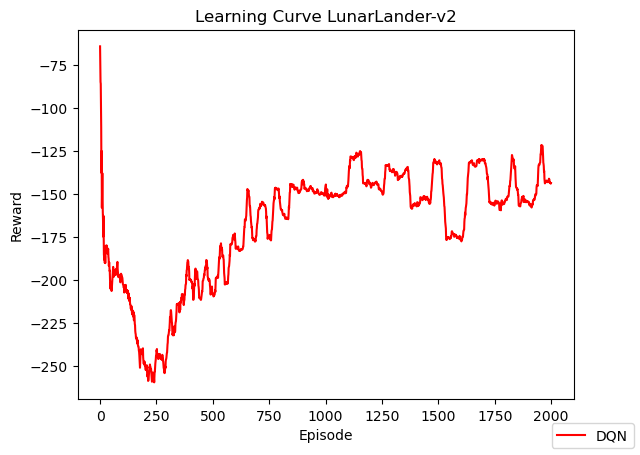

In [14]:
print("Seed = 1")
for i in envs:
    print("ENVIRONMENT:-----------", i)
    env = gym.make(i)
    res=[]
    for j in algos:
        print("Algorithm:", j[2])
        rewards = []
        aver_reward = []
        aver = deque(maxlen=100)
        state_size = env.observation_space.shape[0]
        action_size=env.action_space.n
        batch_size = 4
        seed = 1
        agent = Agent(state_size, action_size, hidden_size, num_layers, batch_size, seed, ddqn=j[0], priority=j[1])
        epsilon = epsilon_start                    # initialize epsilon
       
        for i_episode in tqdm(range(1, n_episodes+1)):
            if i_episode < 3 or i_episode > 1998:
                print("Iteration number: ", i_episode - 1)
            state = env.reset()
            score = 0
#             max_t = 200
            for t in range(max_t):
                action = agent.act(state, epsilon)
                step_result = env.step(action)
                next_state, reward, done, _ = step_result[:4]
                next_state = (next_state, {})
                agent.step(state, action, reward, next_state, done, state_size)
                
                state = next_state
                score = score + reward
                if done:
                    break 
            if i_episode < 3 or i_episode > 1998:
                print("Score: ", score)

            aver.append(score)     
            aver_reward.append(np.mean(aver))
            rewards.append(score)
            epsilon = max(epsilon_end, epsilon_decay*epsilon) # decrease epsilon
            
        reward="model/Seed41_"+i+"_LSTMDQN_"+str(n_episodes)+"_"+str(datetime.now().strftime("%Y%m%d%H%M%S"))
        torch.save(agent.qnetwork_local.state_dict(),reward+'.pt')
        res.append(aver_reward)
        print("----------------End Algorithm--------------------")
    
    fig=plt.figure()   
    
    reward='plots/Seed42_'+i+'_LSTMDQN_result'+str(datetime.now().strftime("%Y%m%d%H%M%S"))
    df=pd.DataFrame({'DQN':res[0]})
    df.to_csv(reward+'.csv')
    print("------------------------End Environment-------------------")
    
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(df['DQN'], 'r', label='DQN')
    
    plt.title('Learning Curve '+i)

    #Insert the legends in the plot
    fig.legend(loc='lower right')
    fig.savefig(reward+'.png', dpi=100)

## 8. Demonstration with random policy 

In [ ]:
# Load the environment
env_name = 'MountainCar-v0'  # Change this to the environment you want to simulate
env = gym.make(env_name, render_mode = 'human')

# Get environment parameters
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initialize the agent
agent = Agent(state_size, action_size, seed=65)  

# Simulate the model in the environment with random actions
scores = []
n_episodes = 100  # Number of episodes for simulation
max_t = 1000  # Maximum number of timesteps per episode

for i_episode in tqdm(range(1, n_episodes+1)):
    state = env.reset()
    env.render()
    score = 0
    
    for t in range(max_t):
        action = agent.act(state, epsilon=0.5) 
        step_result = env.step(action)
        next_state, reward, done, _ = step_result[:4]
        state = next_state
        score = score + reward
        if done:
            break
    print(score)        
    scores.append(score)

# Close the environment
env.close()

# Print average score
print("Average score with random actions:", np.mean(scores))

## 9. Demonstration with learned policy

In [ ]:
# Load the environment
env_name = 'MountainCar-v0'  # Change this to the environment you want to simulate
env = gym.make(env_name, render_mode = 'human')

# Get environment parameters
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initialize the agent
agent = Agent(state_size, action_size, seed=1)  
# Load the model weights
model_path = 'model/Seed1_MountainCar-v0_PriorityDDQN_4000_20240405161249.pt'  # Path to your trained model
agent.qnetwork_local.load_state_dict(torch.load(model_path))
agent.qnetwork_local.eval()

# Simulate the model in the environment
scores = []
n_episodes = 100  # Number of episodes for simulation
max_t = 1000  # Maximum number of timesteps per episode

for i_episode in tqdm(range(1, n_episodes+1)):
    state = env.reset()
    env.render()
    score = 0
    
    for t in range(max_t):
        action = agent.act(state, epsilon=0.)  # Greedy action selection, no exploration
        step_result = env.step(action)
        next_state, reward, done, _ = step_result[:4]
        state = next_state
        score = score + reward
        if done:
            break
    print(score)        
    scores.append(score)

# Close the environment
env.close()

# Print average score
print("Average score:", np.mean(scores))

## 10. Draw the shaded plot for each case

Standard deviation:  0       163.474949
1       100.444962
2        75.915617
3        62.241312
4        65.174756
           ...    
3995     69.422866
3996     70.535840
3997     70.094424
3998     73.780648
3999     74.949975
Length: 4000, dtype: float64
Mean:  0      -250.903886
1      -231.173764
2      -220.472175
3      -204.139179
4      -195.567122
           ...    
3995   -179.953481
3996   -180.219427
3997   -180.415647
3998   -182.397746
3999   -182.755575
Length: 4000, dtype: float64


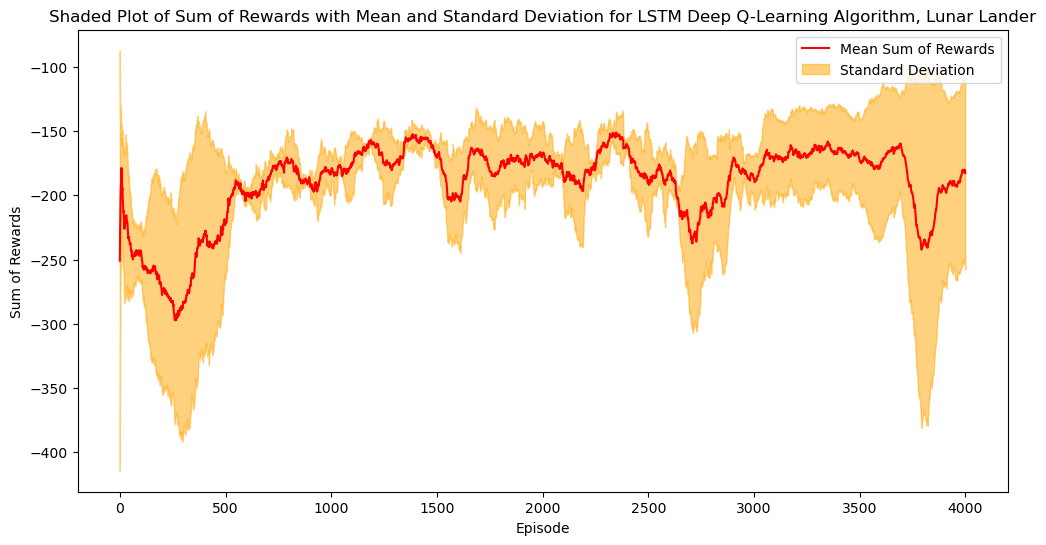

In [4]:
# Step 1: Read Data from CSV
df = pd.read_csv('plots/LSTMDQN_LunarLander-v2.csv')

# Step 2: Remove the first row (Episodes, Run 1, Run 2, Run 3) to keep only the rewards data
# df = df.drop(0)

# Step 3: Convert the remaining DataFrame to numeric values
df = df.apply(pd.to_numeric)

# Step 4: Select only the three late columns (Run 1, Run 2, Run 3)
later_columns = df.iloc[:, 1:4]

# Step 5: Calculate Mean and Standard Deviation for the three later columns
mean_values = later_columns.mean(axis=1)
std_values = later_columns.std(axis=1)
print("Standard deviation: ", std_values)
print("Mean: ", mean_values)

# Step 6: Plot the Data
plt.figure(figsize=(12, 6))
plt.plot(mean_values, label='Mean Sum of Rewards', color = "red")
plt.fill_between(mean_values.index, mean_values - std_values, mean_values + std_values, alpha=0.5, label='Standard Deviation', color = "orange")
plt.xlabel('Episode')
plt.ylabel('Sum of Rewards')
plt.title('Shaded Plot of Sum of Rewards with Mean and Standard Deviation for LSTM Deep Q-Learning Algorithm, Lunar Lander')
plt.savefig('plots/shaded_plot_LSTMDQN_LunarLander.png')
plt.legend()
plt.show()